In [304]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import pickle
import io
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, sample_from_logits_simple
gin.enter_interactive_mode()
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices

In [305]:
ckpt = '/home/sergei/ray_results/5x5_1f1c1k_rec_nonlin_gnn_gumbel_siamese_l2_stop_after_completes/main_fcn_4dc68_00000_0_2021-01-31_20-05-37/checkpoint_1000/checkpoint'

In [306]:
class LinearModel(nn.Module):
    def __init__(self, input_shape):
        super(LinearModel, self).__init__()
        self.layer = nn.Linear(in_features=10, out_features=1, bias=True)
    def forward(self, x):
        return self.layer(x)

In [307]:
import ray
ray.init(address='10.90.38.7:6379', ignore_reinit_error=True)

2021-01-31 20:55:37,861	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 10.90.38.7:6379
2021-01-31 20:55:37,863	ERROR worker.py:660 -- Calling ray.init() again after it has already been called.


In [308]:
# https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [309]:
with open(ckpt, 'rb') as f:
    learner = pickle.load(f)#CPU_Unpickler(f).load()#pickle.load(f)

2021-01-31 20:55:39,304	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 4ad21d4e-63fe-11eb-af1d-90e2baa1a248
Make environment KeyChest-v0 None {}


In [310]:
learner.collect_steps()

In [311]:
ctx = learner._context

In [312]:
ox = ctx['obs_x']
oy = ctx['obs_y']
ax = ctx['action_x']

In [313]:
fit_loss(**ctx)['loss']

tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward>)

In [314]:
from sparse_causal_model_learner_rl.loss.losses import nonzero_proba_loss 

In [315]:
opt = torch.optim.Adam(lr=1e-3, params=learner.model.switch__params)

In [316]:
opt.zero_grad()

In [317]:
l = nonzero_proba_loss(**ctx, do_abs=False)
l['loss'].backward()
print(l)

{'loss': tensor(0., device='cuda:0', grad_fn=<DivBackward0>), 'metrics': {'min_switch_proba': 0.500000536441803}}


In [318]:
opt.step()

In [319]:
list(learner.model.switch__params)[0].grad

tensor([[-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0., -0., -0., -

In [320]:
mask[2, :, 0]

tensor([1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 1.0000], device='cuda:0', grad_fn=<SelectBackward>)

In [321]:
delta.shape

torch.Size([4520, 19])

In [322]:
w = learner.model.model.switch.probas

In [323]:
mask_coeff[:, 0,  1][mask_coeff[:, 0,  1] < 0].sum()

tensor(-1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [324]:
opt = torch.optim.Adam(lr=1e-3, params=learner.model.model__params)
opt_switch = False

In [325]:
opt_switch = True
opt = torch.optim.Adam(lr=1e-3, params=learner.model.switch__params)

In [326]:
losses = []

In [330]:
for _ in tqdm(range(10000)):
    opt.zero_grad()
#     loss = fit_loss(**ctx)['loss']
#     loss.backward()



    f_t1 = learner.decoder(ctx['obs_y'])
    additional_feature_keys = learner.additional_feature_keys
    if additional_feature_keys:
        have_additional = True
        add_features_y = torch.cat([ctx[k] for k in additional_feature_keys], dim=1)
        f_t1 = torch.cat([f_t1, add_features_y], dim=1)

    mse = torch.nn.MSELoss()
    # detaching second part like in q-learning makes the loss jitter

    f_t1_pred = learner.model(learner.decoder(ctx['obs_x']), ctx['action_x'], all=True, enable_switch=True)

    loss = mse(f_t1_pred, f_t1)
    mask = learner.model.model.last_mask
    delta = (f_t1 - f_t1_pred).abs().pow(2)
    
    if opt_switch:

        
        delta_expanded = delta.view(delta.shape[0], 1, delta.shape[1]).expand(-1, 21, -1)
        mask_coeff = (mask - 0.5) * 2

        mask_pos = mask#torch.where(mask_coeff > 0, mask, torch.zeros_like(mask))
        mask_neg = 1 - mask#torch.where(mask_coeff < 0, 1 - mask, torch.zeros_like(mask))
        n_pos = (mask_coeff > 0).sum(dim=0) + 1e-5
        n_neg = (mask_coeff < 0).sum(dim=0) + 1e-5

        mask_pos = mask_pos / n_pos
        mask_neg = mask_neg / n_neg

    #     print(n_pos, n_neg, n_pos + n_neg)

        mask_atleast = ((n_pos >= 1) * (n_neg >= 1))

        mask_coeff = mask_atleast * (mask_pos - mask_neg)

    #     print(mask_coeff)

        p_grad = (delta_expanded * mask_coeff).sum(dim=0)
#         p_grad[p_grad < 0] *= 100
        
        learner.model.model.switch.probas.grad = p_grad.clone()
    else:
        loss.backward()

    opt.step()
    losses.append(loss.item())
    w.data[w < 0.5] = 0.5
#     w.data[w > 0.99] = 0.9

KeyboardInterrupt: 

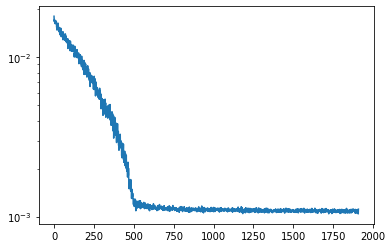

In [331]:
plt.plot(losses)
plt.yscale('log')

(array([  2.,   0.,   3.,   2.,  12., 351.,  13.,   7.,   6.,   3.]),
 array([-0.008168  , -0.00669712, -0.00522624, -0.00375536, -0.00228448,
        -0.0008136 ,  0.00065728,  0.00212815,  0.00359903,  0.00506991,
         0.00654079], dtype=float32),
 <BarContainer object of 10 artists>)

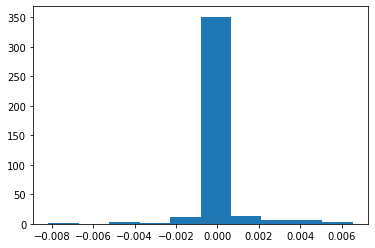

In [332]:
plt.hist(p_grad.flatten().detach().cpu().numpy())

In [333]:
delta.mean(dim=0)

tensor([1.3386e-06, 3.2237e-06, 2.0755e-04, 3.5810e-03, 1.2557e-04, 1.5047e-04,
        1.7856e-04, 4.3900e-04, 2.1833e-04, 1.8845e-04, 3.7044e-04, 1.4254e-03,
        7.6836e-05, 4.2294e-04, 3.7892e-04, 1.4352e-05, 6.3750e-05, 7.2998e-03,
        5.3582e-03], device='cuda:0', grad_fn=<MeanBackward1>)

In [334]:
delta.mean()

tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)

<AxesSubplot:>

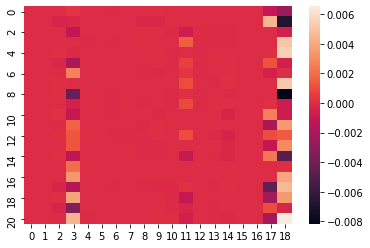

In [335]:
sns.heatmap(learner.model.model.switch.probas.grad.data.detach().cpu().numpy())

In [336]:
from keychest.features_xy import dict_to_arr, arr_to_dict, obs_features_handcoded

keys = sorted(obs_features_handcoded(learner.env.engine).keys())
keys_add = learner.additional_feature_keys

In [337]:
true_model = {
    'button__x': ['button__x'],
    'button__y': ['button__y'],
    'chest__00__x': ['chest__00__x', 'chest__00__y', 'keys', 'player__x', 'player__y'],
    'chest__00__y': ['chest__00__x', 'chest__00__y', 'keys', 'player__x', 'player__y'],
    'food__00__x': ['food__00__x', 'food__00__y', 'player__x', 'player__y'],
    'food__00__y': ['food__00__x', 'food__00__y', 'player__x', 'player__y'],
    'health': ['food__00__x', 'food__00__y', 'player__x', 'player__y', 'health'],
    'key__00__x': ['key__00__x', 'key__00__y', 'player__x', 'player__y'],
    'key__00__y': ['key__00__x', 'key__00__y', 'player__x', 'player__y'],
    'keys': ['keys', 'key__00__x', 'key__00__y', 'player__x', 'player__y', 'chest__00__x', 'chest__00__y'],
    'lamp_off__x': ['lamp_off__x', 'lamp_on__x', 'button__x', 'button__y', 'player__x', 'player__y'],
    'lamp_off__y': ['lamp_off__y', 'lamp_on__y', 'button__x', 'button__y', 'player__x', 'player__y'],
    'lamp_on__x': ['lamp_off__x', 'lamp_on__x', 'button__x', 'button__y', 'player__x', 'player__y'],
    'lamp_on__y': ['lamp_off__y', 'lamp_on__y', 'button__x', 'button__y', 'player__x', 'player__y'],
    'lamp_status': ['lamp_on__x', 'lamp_on__y', 'lamp_off__x', 'lamp_off__y', 'player__x', 'player__y'],
    'player__x': ['player__x'],
    'player__y': ['player__y'],
    'done_y': ['player__x', 'player__y', 'food__00__x', 'food__00__y', 'health'],
    'rew_y': ['player__x', 'player__y', 'food__00__x', 'food__00__y', 'key__00__x', 'key__00__y', 'chest__00__x', 'chest__00__y']
}

true_model_a = {
    'player__x': [0, 1, 2, 3],
    'player__y': [0, 1, 2, 3]
}

df_a_true = pd.DataFrame(np.zeros_like(learner.model.Ma), columns=[0, 1, 2, 3], index=keys+keys_add)

for key, vals in true_model_a.items():
    for v in vals:
        df_a_true.loc[key, v] = 1.0

df_true = pd.DataFrame(np.zeros_like(learner.model.Mf), columns=keys, index=keys+keys_add)
for key, vals in true_model.items():
    for v in vals:
#         print(key, v)
        df_true.loc[key, v] = 1.0

<AxesSubplot:>

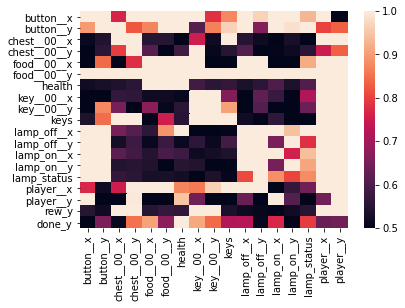

In [338]:
sns.heatmap(pd.DataFrame(learner.model.Mf, columns=keys, index=keys+keys_add))

<AxesSubplot:>

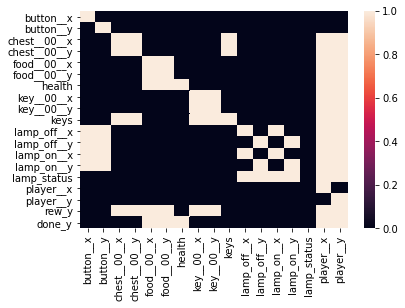

In [293]:
sns.heatmap(df_true)

<AxesSubplot:>

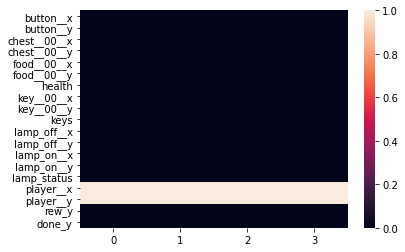

In [294]:
sns.heatmap(df_a_true)

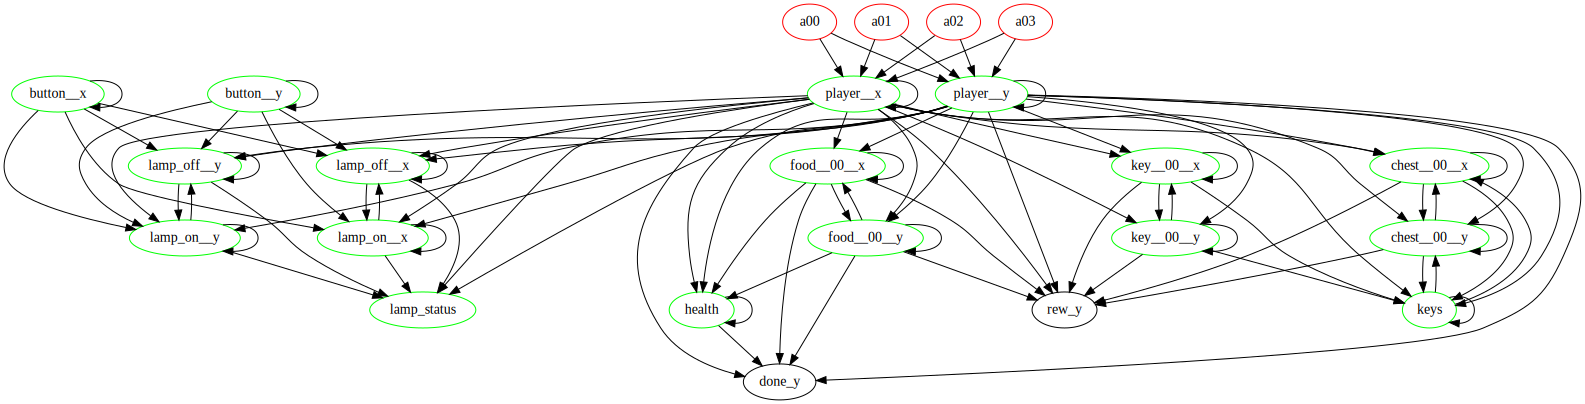

In [115]:
m = learner
m.Mf = df_true
m.Ma = df_a_true
graph_for_matrices(m, feature_names=keys)[0]

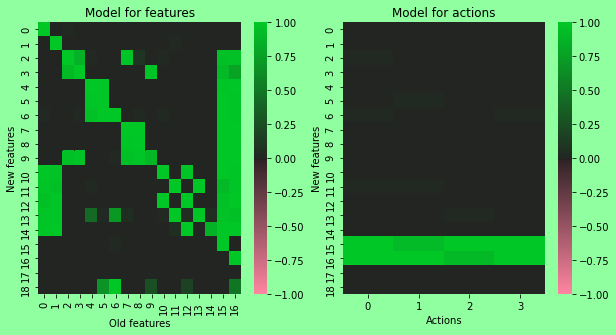

In [116]:
f = learner.visualize_model()

In [23]:
pd.DataFrame(learner.model.Mf, index=keys+keys_add, columns=keys)

,button__x,button__y,chest__00__x,chest__00__y,food__00__x,food__00__y,health,key__00__x,key__00__y,keys,lamp_off__x,lamp_off__y,lamp_on__x,lamp_on__y,lamp_status,player__x,player__y
button__x,1.000000,0.010113,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
button__y,0.000000,0.999994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chest__00__x,0.000000,0.000000,0.999865,0.971181,0.000000,0.000000,0.000000,0.414437,0.000000,0.987936,0.000000,0.001806,0.000104,0.000000,0.000000,0.989415,0.991482
chest__00__y,0.017365,0.001142,0.988290,1.000000,0.000000,0.000021,0.000368,0.604095,0.188784,0.997015,0.000000,0.000000,0.000000,0.000336,0.000094,0.964088,0.939604
food__00__x,0.000000,0.000173,0.000000,0.002773,0.995670,0.992746,0.030721,0.000000,0.000806,0.000815,0.000000,0.000000,0.000975,0.000000,0.004882,0.998005,1.000000
food__00__y,0.020201,0.000000,0.000000,0.000000,0.993287,0.997006,0.156876,0.000005,0.000000,0.000000,0.000000,0.000000,0.000045,0.000000,0.000000,0.997599,0.996271
health,0.839027,0.822786,0.000287,0.690736,0.266460,0.815333,0.999265,0.000069,0.728852,0.007881,0.380571,0.781004,0.000000,0.000000,0.004761,0.993038,1.000000
key__00__x,0.022902,0.000000,0.000000,0.004919,0.000000,0.000000,0.000161,1.000000,0.995670,0.023430,0.000000,0.000000,0.004736,0.000000,0.000000,0.985768,0.978172
key__00__y,0.000035,0.000000,0.000000,0.000000,0.000043,0.000000,0.000000,0.991341,1.000000,0.000000,0.000000,0.000114,0.000000,0.000675,0.000000,0.990412,0.980450
keys,0.000000,0.000521,0.978292,0.782309,0.000000,0.001757,0.024245,0.999698,0.998613,0.761495,0.007104,0.000000,0.000134,0.008337,0.000000,1.000000,0.993836


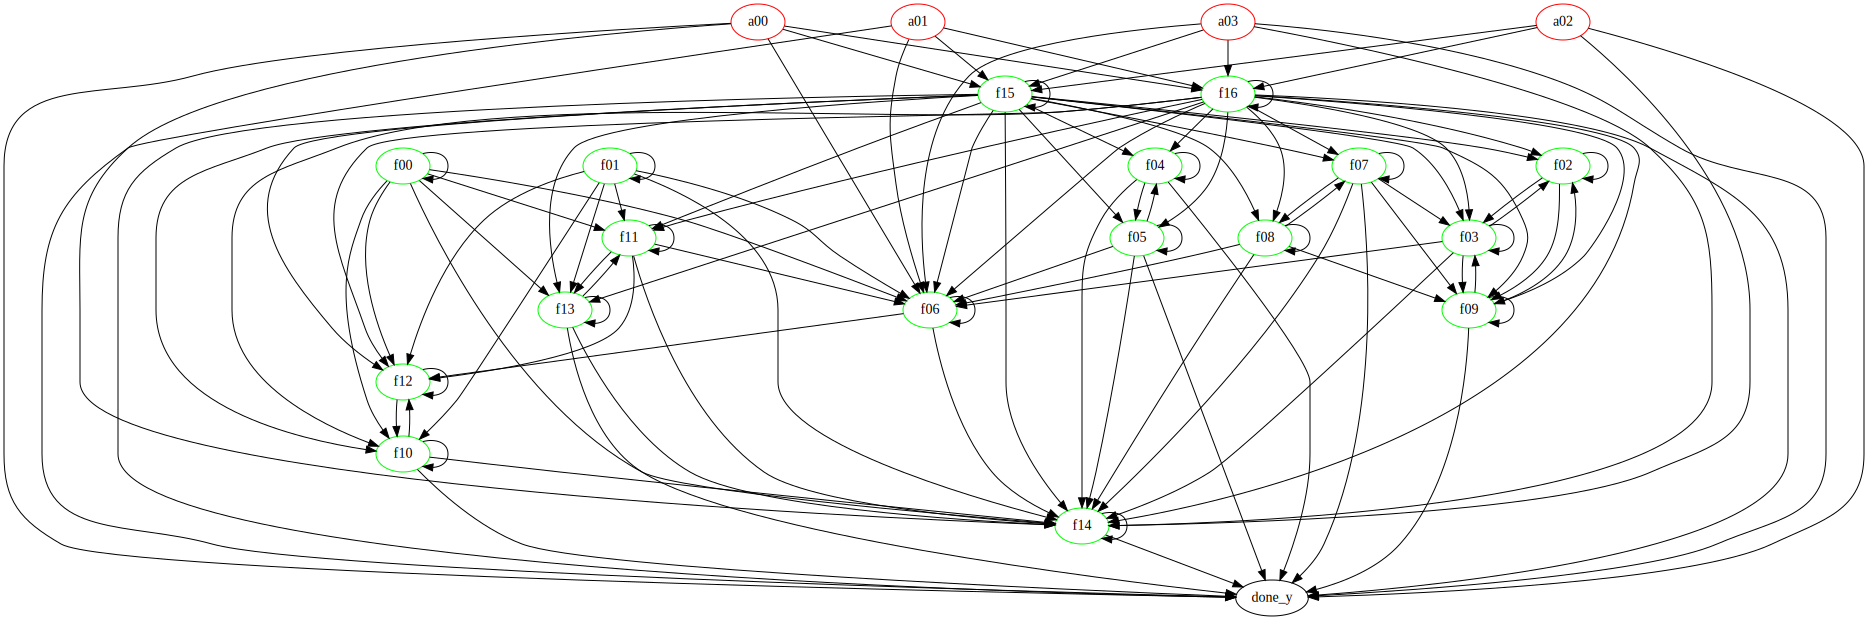

In [24]:
learner.visualize_graph()[1]

In [30]:
context_rewriter(function=fit_loss,
                rewrite={'model': 'non_sparse_model'},
                **ctx)

{'loss': tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>),
 'metrics': {'mean_feature': 0.6068742871284485}}

In [31]:
fit_loss(**ctx)

{'loss': tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward>),
 'metrics': {'mean_feature': 0.6068742871284485}}

In [75]:
model_forward_kwargs={'enable_switch': False}
fit_loss(**ctx, **model_forward_kwargs)

{'loss': tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward>),
 'metrics': {'mean_feature': 0.6068742871284485}}

In [93]:
f_t1 = learner.decoder(ctx['obs_y'])
additional_feature_keys = ctx['additional_feature_keys']
have_additional = True
add_features_y = torch.cat([ctx[k] for k in additional_feature_keys], dim=1)
f_t1 = torch.cat([f_t1, add_features_y], dim=1)

mse = torch.nn.MSELoss()
# detaching second part like in q-learning makes the loss jitter
loss = mse(learner.model(learner.decoder(ctx['obs_x']), ctx['action_x'], all=have_additional, **model_forward_kwargs), f_t1)

metrics = {'mean_feature': torch.mean(torch.abs(f_t1)).item()}

In [99]:
learner.model.model.model.fc01.in_features

42

In [94]:
loss

tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward>)

In [84]:
learner.model(learner.decoder(ctx['obs_x']), ctx['action_x'], all=True, enable_switch=False)

tensor([[-0.9773, -0.4892,  0.9905,  ...,  0.9432,  0.0166,  0.0090],
        [-0.9823, -0.4797,  0.9881,  ...,  0.4856,  0.0152,  0.0152],
        [-0.9827, -0.4741,  0.9880,  ..., -0.0188,  0.0158,  0.0141],
        ...,
        [-0.9960, -0.4797,  0.9783,  ..., -1.0108,  0.0096,  0.0168],
        [-0.9911, -0.4718,  0.9818,  ..., -1.0063,  0.0125, -0.0551],
        [-0.9963, -0.4738,  0.9890,  ..., -0.5059,  0.0172, -0.0231]],
       device='cuda:0', grad_fn=<ViewBackward>)

In [86]:
learner.model.zero_grad()

In [87]:
learner.model.load_state_dict(learner.model.state_dict())

<All keys matched successfully>

In [88]:
fit_loss(**ctx, model_forward_kwargs={'detach_mask': True})['loss'].backward()

In [89]:
learner.model.model_fadd_0001.switch.logits.grad[1, keys.index('health')]

tensor(-0.0009, device='cuda:0')

In [91]:
# 1k iterations should be enough???
1/1e-3

1000.0

In [100]:
logits = learner.model.model_fadd_0001.switch.logits
logits.grad = None

In [44]:
def loss_with_logits(v):
    fin = keys.index('health')
    logits[0, fin], logits[1, fin] = -v, v
    loss = fit_loss(**ctx)['loss'].item()
    return loss

In [52]:
space = np.linspace(-5, 5, 100)

In [55]:
losses = [np.mean([loss_with_logits(v) for _ in range(10)]) for v in tqdm(space)]

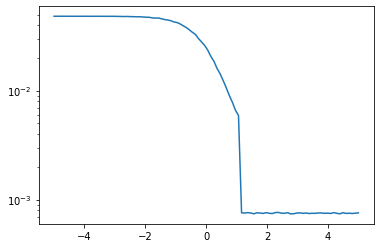

In [56]:
plt.plot(space, losses)
plt.yscale('log')

In [101]:
logits[1, keys.index('health')]

tensor(-0.8989, device='cuda:0', grad_fn=<SelectBackward>)

In [115]:
m.model_fout_0000.switch.softmaxed()

tensor([0.9526, 0.1057, 0.1057, 0.1058, 0.1057, 0.9526, 0.9526, 0.1056, 0.1058,
        0.1057, 0.1057, 0.8808, 0.1057, 0.1057, 0.1057, 0.1057, 0.1058, 0.1057,
        0.1057, 0.1057, 0.1057], device='cuda:0', grad_fn=<SelectBackward>)

In [114]:
m = learner.model
for fout in range(m.n_features + m.n_additional_features):
    if fout >= m.n_features:
        fout_add = fout - m.n_features
        logits = getattr(m, m.additional_models[fout_add]).switch.logits
    else:
        logits = getattr(m, m.models[fout]).switch.logits
        
#     print(fout)
        
    for fin in range(m.n_features):
        orig_logits0, orig_logits1 = logits[0, fin].item(), logits[1, fin].item()

        # trying 0...
        logits[0, fin], logits[1, fin] = 5, -5
        loss_0 = fit_loss(**ctx)['loss'].item()
        
        
        # trying 1...
        logits[0, fin], logits[1, fin] = -5, 5
        loss_1 = fit_loss(**ctx)['loss'].item()
        
        logits[0, fin], logits[1, fin] = orig_logits0, orig_logits1
        
        loss_ratio = loss_0 / loss_1
        
        if loss_ratio > 1.1:
            print('turn on feature', (keys + keys_add)[fout], keys[fin])
            logits[0, fin], logits[1, fin] = -1.5, 1.5

turn on feature button__x button__x
turn on feature button__x food__00__y
turn on feature button__x health
turn on feature button__y button__x
turn on feature button__y button__y
turn on feature button__y chest__00__x
turn on feature button__y lamp_off__x
turn on feature chest__00__x chest__00__x
turn on feature chest__00__y chest__00__y
turn on feature chest__00__y keys
turn on feature food__00__x food__00__x
turn on feature food__00__x food__00__y
turn on feature food__00__x lamp_on__x
turn on feature food__00__x player__x
turn on feature food__00__x player__y
turn on feature food__00__y food__00__x
turn on feature food__00__y food__00__y
turn on feature food__00__y player__x
turn on feature food__00__y player__y
turn on feature health chest__00__y
turn on feature health food__00__x
turn on feature health food__00__y
turn on feature health health
turn on feature health player__x
turn on feature key__00__x key__00__x
turn on feature key__00__x key__00__y
turn on feature key__00__x lam

In [107]:
fit_loss(**ctx)

{'loss': tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'mean_feature': 0.6767909526824951,
  'mean_additional_feature': 0.05813385918736458,
  'loss_main': 0.04710227623581886,
  'loss_additional': 0.019305502995848656}}

In [11]:
oy_pred = learner.model(f_t=ox, a_t=ax)
oy_pred_nosparse = learner.non_sparse_model(f_t=ox, a_t=ax)

In [ ]:
        add_features_y = torch.cat([kwargs[k] for k in additional_feature_keys], dim=1)
        loss_additional = mse(model(decoder(obs_x), action_x, additional=True), add_features_y)

In [29]:
learner.model(f_t=ox, a_t=ax, additional=True)

tensor([[ 2.3909e-04,  1.1392e-01],
        [ 1.0046e-01,  1.0674e-01],
        [ 2.9988e-01,  7.9058e-02],
        ...,
        [ 2.8248e-05,  5.7320e-02],
        [-1.6586e-05,  6.1120e-02],
        [-8.4626e-05,  6.9533e-02]], device='cuda:0', grad_fn=<CatBackward>)

In [27]:
(oy_pred - oy).pow(2).mean()

tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)

In [28]:
(oy_pred_nosparse - oy).pow(2).mean()

tensor(4.2184e-05, device='cuda:0', grad_fn=<MeanBackward0>)

<AxesSubplot:>

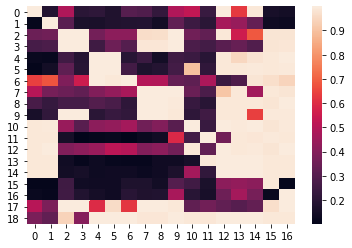

In [179]:
sns.heatmap(learner.model.Mf)

<AxesSubplot:>

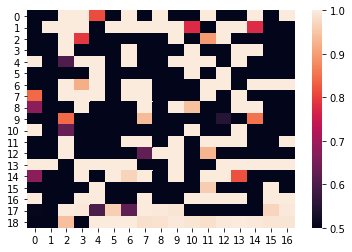

In [217]:
sns.heatmap(learner.model.Mf)

In [218]:
# most features are bad
(oy_pred - oy).pow(2).mean(0)

tensor([0.4873, 0.4832, 0.3657, 0.3342, 0.5606, 0.5150, 0.3995, 0.4041, 0.4693,
        1.2049, 0.5493, 0.3676, 1.1948, 1.0183, 0.9657, 0.4987, 0.5061],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [316]:
# random init
ms = learner.non_sparse_model.all_models
for m in ms:
    getattr(learner.model, m).model.__init__(input_shape=(learner.model.n_features + learner.model.n_actions,),
                                            output_shape=(1,))
    getattr(learner.model, m).model.to(learner.device)
# list(getattr(learner.model, ms[0]).model.fc01.parameters())

In [387]:
opt = torch.optim.Adam(params=learner.model.model__params, lr=1e-3)

In [318]:
for m in learner.model.all_models:
    getattr(learner.model, m).switch.sample_threshold = 0.9

In [238]:
assert learner.non_sparse_model.all_models == learner.model.all_models
for key in learner.non_sparse_model.all_models:
    m_nsp_i = getattr(learner.non_sparse_model, key)
    m_i = getattr(learner.model, key).model
    m_i.load_state_dict(m_nsp_i.state_dict())

In [223]:
losses = []

In [382]:
opt = torch.optim.Adam(params=learner.model.switch__params, lr=1e-3)

In [ ]:
for _ in tqdm(range(50000)):
    opt.zero_grad()
    oy_pred = learner.model(f_t=ox, a_t=ax)
    loss = (oy_pred - oy).pow(2).mean()
    loss.backward()
    opt.step()
    losses.append(loss.item())

In [284]:
### 

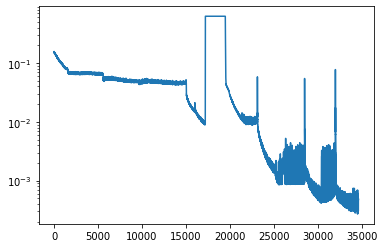

In [393]:
plt.plot(losses)
plt.yscale('log')

In [337]:
[x[1].min() for x in learner.model.switch__params]

[tensor(-0.3150, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.3007, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1131, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1347, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.2559, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1408, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5359, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.7687, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.1943, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.2939, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.1320, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.3136, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0301, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1.0984, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.1221, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.5223, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.3726, device='cuda:0', grad_fn=<MinBackward1>),
 te

In [366]:
[getattr(learner.model, m).switch.softmaxed().min() for m in learner.model.all_models]

[tensor(0.3911, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.4499, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.6723, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5477, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.0262, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5568, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.4919, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.0939, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.6468, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1814, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.2581, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.6737, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.2943, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.9007, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1432, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.6316, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.4051, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5000

In [341]:
for p in learner.model.switch__params:
    p_orig = p.data.detach().clone()
    print(p_orig)
#     break
    p.data[1, p_orig[1] < 0] = 0
    p.data[0, p_orig[1] < 0] = 0

tensor([[-2.2689, -0.1689, -6.2526, -1.0999,  0.1009, -0.1912, -4.0945, -1.1123,
         -6.4583, -1.0994, -2.2313, -6.3194, -1.1019, -1.0992, -6.4341,  0.3251,
         -5.4444, -3.3842, -2.6222, -2.6231, -2.4681],
        [ 2.2689,  0.1689,  6.2526,  1.0999, -0.1009,  0.1912,  4.0945,  1.1123,
          6.4584,  1.0994,  2.2313,  6.3194,  1.1019,  1.0992,  6.4341, -0.3251,
          5.4444,  3.3842,  2.6222,  2.6231,  2.4681]], device='cuda:0')
tensor([[ 0.3160, -7.8777, -6.9329, -6.2106, -1.0990, -5.4199, -6.4777, -7.7424,
         -7.1228, -7.3047, -1.0988, -1.5841, -7.5017, -7.3072, -1.1531,  0.2827,
         -0.9270, -1.0993, -6.6940, -1.0990, -6.3193],
        [-0.3160,  7.8772,  6.9329,  6.2106,  1.0990,  5.4199,  6.4778,  7.7421,
          7.1228,  7.3047,  1.0988,  1.5841,  7.5016,  7.3072,  1.1531, -0.2827,
          0.9270,  1.0993,  6.6940,  1.0990,  6.3193]], device='cuda:0')
tensor([[-0.3735, -0.3550, -8.6088, -5.1537, -0.3251, -0.9286, -0.6295, -0.1110,
         -0.254

In [111]:
for key, param in learner.model.named_parameters():
    if 'switch' not in key:
        print(key)
        if 'bias' in key:
            torch.nn.init.zeros_(param)
        else:
            torch.nn.init.xavier_uniform_(param)

model_fout_0000.model.fc01.weight
model_fout_0000.model.fc01.bias
model_fout_0000.model.fc02.weight
model_fout_0000.model.fc02.bias
model_fout_0000.model.fc03.weight
model_fout_0000.model.fc03.bias
model_fout_0000.model.fc04.weight
model_fout_0000.model.fc04.bias
model_fout_0001.model.fc01.weight
model_fout_0001.model.fc01.bias
model_fout_0001.model.fc02.weight
model_fout_0001.model.fc02.bias
model_fout_0001.model.fc03.weight
model_fout_0001.model.fc03.bias
model_fout_0001.model.fc04.weight
model_fout_0001.model.fc04.bias
model_fout_0002.model.fc01.weight
model_fout_0002.model.fc01.bias
model_fout_0002.model.fc02.weight
model_fout_0002.model.fc02.bias
model_fout_0002.model.fc03.weight
model_fout_0002.model.fc03.bias
model_fout_0002.model.fc04.weight
model_fout_0002.model.fc04.bias
model_fout_0003.model.fc01.weight
model_fout_0003.model.fc01.bias
model_fout_0003.model.fc02.weight
model_fout_0003.model.fc02.bias
model_fout_0003.model.fc03.weight
model_fout_0003.model.fc03.bias
model_fout